In [1]:
# data manipulation 
import numpy as np
import pandas as pd

# Time-manipulation libraries:
from datetime import datetime
from time import strftime
import itertools

# data visualization 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Split/Modeling libraries:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.api as sm
from statsmodels.tsa.api import Holt

# web-based requests
import requests

# Importing the os library specifically for reading the csv once I've created the file in my working directory.
import os

# My functions:
import acquire
import prepare
# import explore - need to complete this soon!

credentials loaded successfully
End of file.


## Plan:

- Plan for this project MVP is simply to walk through the steps we learned in the lesson, to get a baseline. 
- Then, I want to create moving averages
- Then create bollinger bands
- End up with crossover and B-band breakouts noted
- Finally, attempt predicting future performance based on those conditions.

## Acquiring the Data

In [2]:
# Acquring data from csv located at: http://www.cboe.com/micro/buywrite/dailypricehistory.xls

In [3]:
df = pd.read_csv('cboe_data_spx.csv')
print(df.shape)
df.head()

(8337, 2)


,date,spx
0,30-Jun-86,250.84
1,01-Jul-86,252.04
2,02-Jul-86,252.70
3,03-Jul-86,251.79
4,07-Jul-86,244.05


In [4]:
df.isnull().sum()

date    0
spx     0
dtype: int64

In [5]:
df.date = pd.to_datetime(df.date)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8337 entries, 0 to 8336
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    8337 non-null   datetime64[ns]
 1   spx     8337 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 130.4 KB


In [7]:
df = df.set_index('date').sort_index()
df

,spx
date,
1986-06-30,250.84
1986-07-01,252.04
1986-07-02,252.70
1986-07-03,251.79
1986-07-07,244.05
...,...
2019-07-22,2985.03
2019-07-23,3005.47
2019-07-24,3019.56


In [8]:
df.index.dtype

dtype('<M8[ns]')

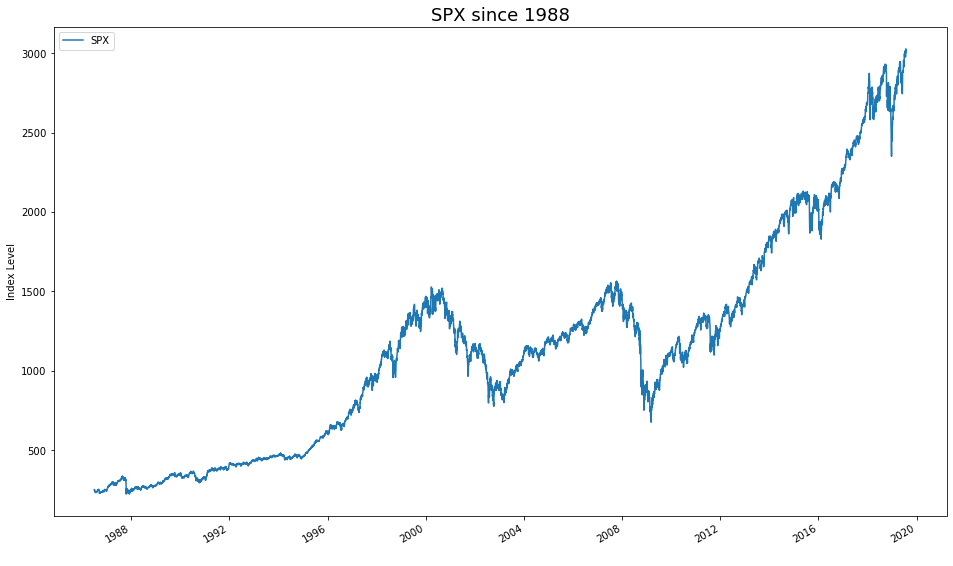

In [9]:
df.plot(figsize = (16, 10))
plt.legend(['SPX'])
plt.title("SPX since 1988", fontsize = 18)
plt.xlabel(" ")
plt.ylabel("Index Level")
plt.show()

## Prepare

- This data has missing days because of weekends, so I need to figure out what to do with that.

In [10]:
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size + validate_size)
validate_end_index = train_size + validate_size

# split into train, validate, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index :]

In [11]:
train

,spx
date,
1986-06-30,250.84
1986-07-01,252.04
1986-07-02,252.70
1986-07-03,251.79
1986-07-07,244.05
...,...
2002-12-26,889.66
2002-12-27,875.40
2002-12-30,879.39


In [12]:
print(len(train) + len(validate) + len(test) == len(df))

True


In [13]:
print(df.head(1) == train.head(1))

             spx
date            
1986-06-30  True


In [14]:
pd.concat([train.tail(1), validate.head(1)])
pd.concat([validate.tail(1), test.head(1)])

,spx
date,
2012-12-07,1418.07
2012-12-10,1418.55


In [15]:
pd.concat([test.tail(1), df.tail(1)])

,spx
date,
2019-07-26,3025.86
2019-07-26,3025.86


In [16]:
train.index.dtype

dtype('<M8[ns]')

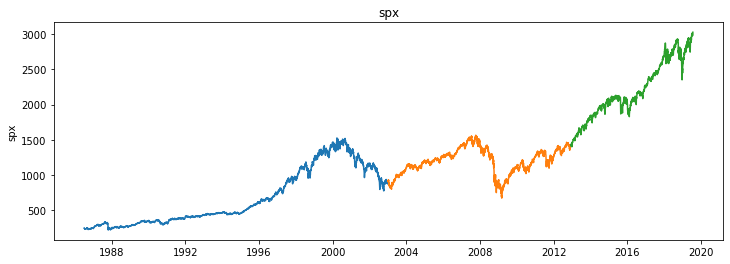

In [17]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

## Explore

<AxesSubplot:xlabel='date'>

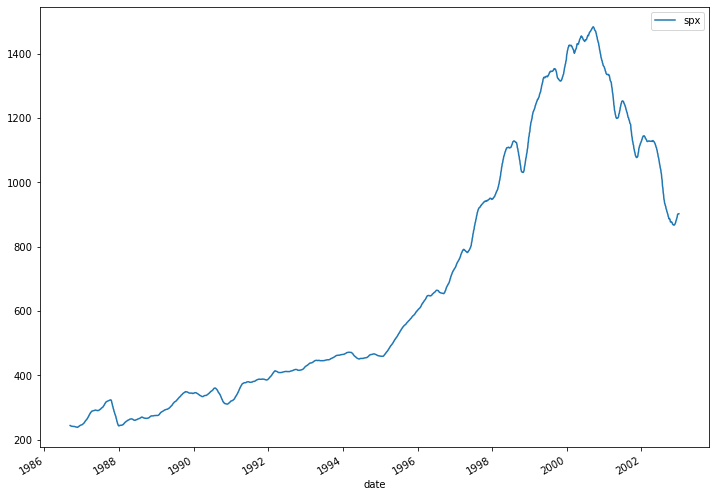

In [18]:
# Moving average (50 day):

train.rolling(50).mean().plot(figsize = (12, 9))

<AxesSubplot:xlabel='date'>

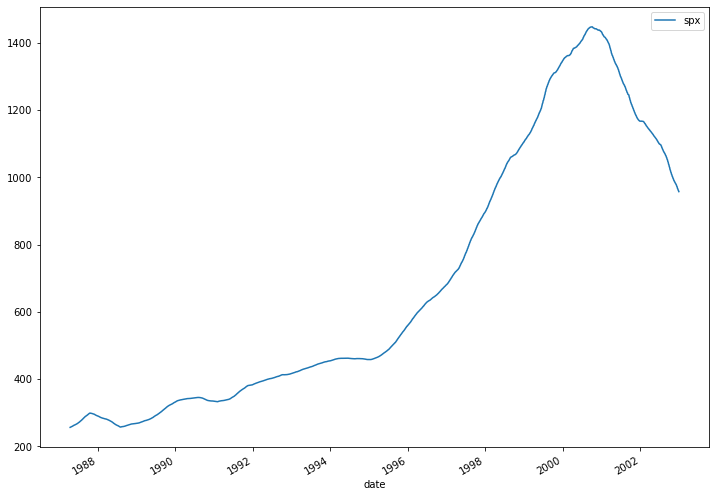

In [19]:
# Moving average (200 day):

train.rolling(200).mean().plot(figsize = (12, 9))

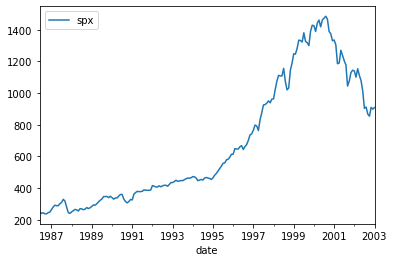

In [20]:
# Monthly average:

train.resample("MS").mean().plot()
plt.show()

<AxesSubplot:xlabel='date'>

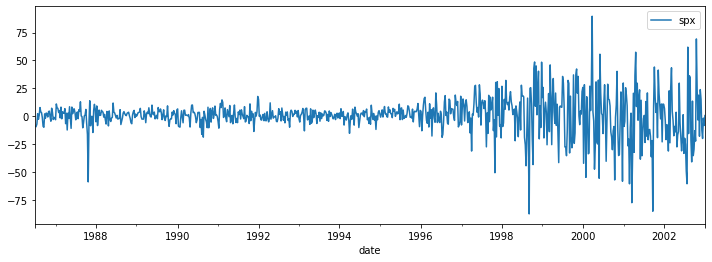

In [21]:
# Moving difference:

train.resample("W").mean().diff(periods = 1).plot(figsize = (12, 4))

<AxesSubplot:xlabel='date'>

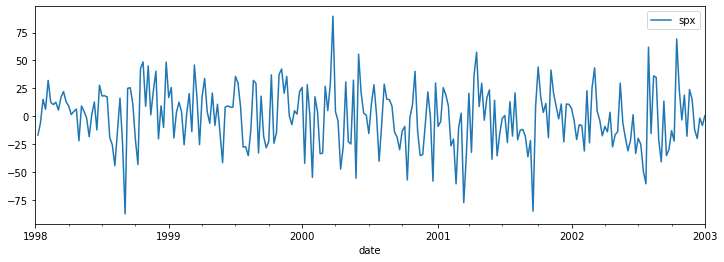

In [22]:
# Obviously a lot noisier near the end of the data timeframe, but is that just because of higher levels? 
# I haven't normalized for that.

# Looking just at the last few years of the train dataset:


train["1998":].resample("W").mean().diff(periods = 1).plot(figsize = (12, 4))

#### Takeaway:
- The moving difference is much less variable.
- Still no decernable pattern, but less range of variation.

<AxesSubplot:xlabel='date'>

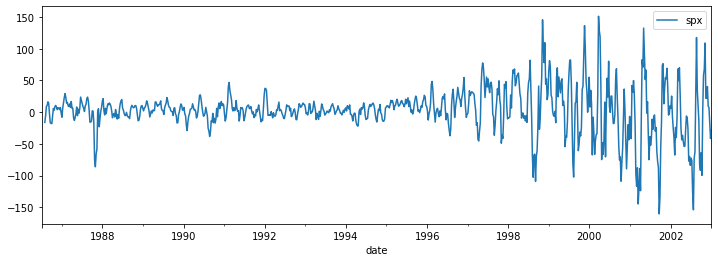

In [23]:
# Moving difference resampling at lower frequency (less samples):

train.resample("W").mean().diff(periods = 4).plot(figsize = (12, 4))

#### Trying to see if there are any seasonality trends I can see

- From the old trader's adage, "Sell in May and stay away", meaning that going to cash over the summer months and coming back to invest in the fall implies a sort of seasonal trend.

In [24]:
train_explore = train.copy()

In [25]:
train_explore['month'] = train_explore.index.month
train_explore.head()

,spx,month
date,,
1986-06-30,250.84,6
1986-07-01,252.04,7
1986-07-02,252.70,7
1986-07-03,251.79,7
1986-07-07,244.05,7


<AxesSubplot:xlabel='month', ylabel='spx'>

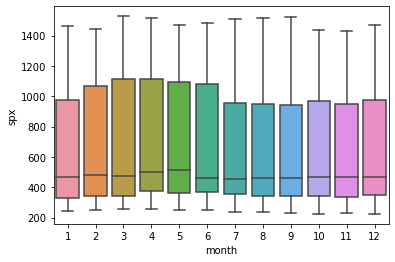

In [26]:
# The summer months are 5 - 8. So can I group by those months?

sns.boxplot(data = train_explore, x = 'month', y = 'spx')

<AxesSubplot:xlabel='month', ylabel='spx'>

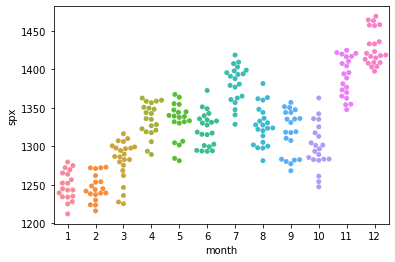

In [27]:
sns.swarmplot(data = train_explore["1999"], x = 'month', y = 'spx')

## Modeling

- Will be using Moving Average to create a forecast. Will attempt to use a 50 day and 200 day moving average.

In [28]:
train.head()

,spx
date,
1986-06-30,250.84
1986-07-01,252.04
1986-07-02,252.70
1986-07-03,251.79
1986-07-07,244.05


In [29]:
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [30]:
# plot and evaluate 
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [31]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [32]:
def make_predictions():
    yhat_df = pd.DataFrame({'spx': [stocks]}, index = validate.index)
    return yhat_df

In [33]:
eval_df

,model_type,target_var,rmse


In [34]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4168 entries, 1986-06-30 to 2003-01-02
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   spx     4168 non-null   float64
dtypes: float64(1)
memory usage: 225.1 KB


### Last Observed Value

In [35]:
stocks = round(train['spx'][-1:][0])
stocks

909

In [37]:
yhat_df = pd.DataFrame({'spx': [stocks]}, index = validate.index)

yhat_df.head()
yhat_df.describe()

,spx
count,2501.0
mean,909.0
std,0.0
min,909.0
25%,909.0
50%,909.0
75%,909.0
max,909.0


spx -- RMSE: 345


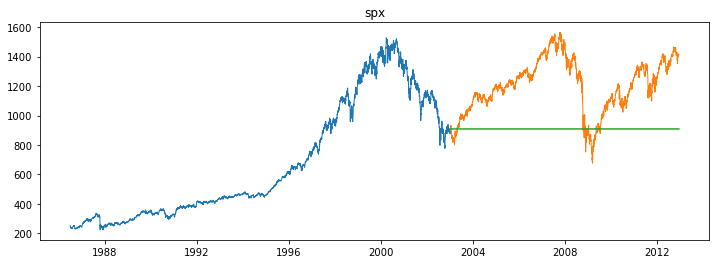

In [38]:
plot_and_eval('spx')

spx -- RMSE: 345


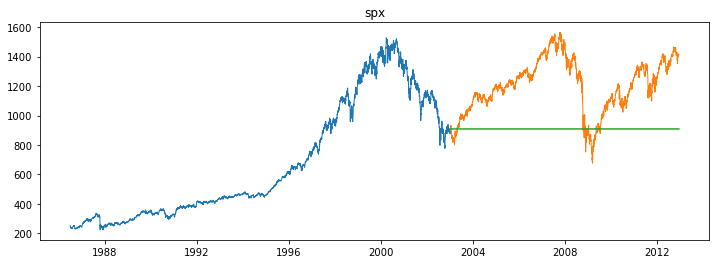

In [40]:
for col in train.columns:
    plot_and_eval(col)

#### Evaluate

In [41]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', target_var = col)
    
eval_df

,model_type,target_var,rmse
0,last_observed_value,spx,345.0


#### Simple Average

In [ ]:
stocks = round()